In [1]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [3]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [9]:
sub1 = pd.read_csv("../submit/v003_017/submission_t_v003_017.csv").set_index("id")
sub2 = pd.read_csv("../submit/v003_019/submission_t_v003_019.csv").set_index("id")
sub3 = pd.read_csv("../submit/v003_023/submission_t_v003_023.csv").set_index("id")
sub4 = pd.read_csv('../submit/v003_022/blending_v003_022_8seeds.csv').set_index("id")

In [10]:
sub_list_df = pd.concat([sub1, sub2, sub3, sub4], axis=1)

In [11]:
sub_list_df.head()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant
id,,,,
4658147,15.93833,12.96126,16.11731,12.36109
4658148,184.42706,183.84759,183.53159,181.24552
4658149,1.97489,0.36315,2.82472,0.97322
4658150,183.83480,183.44374,183.37433,180.20677
4658151,11.44533,11.12745,11.30629,11.20605


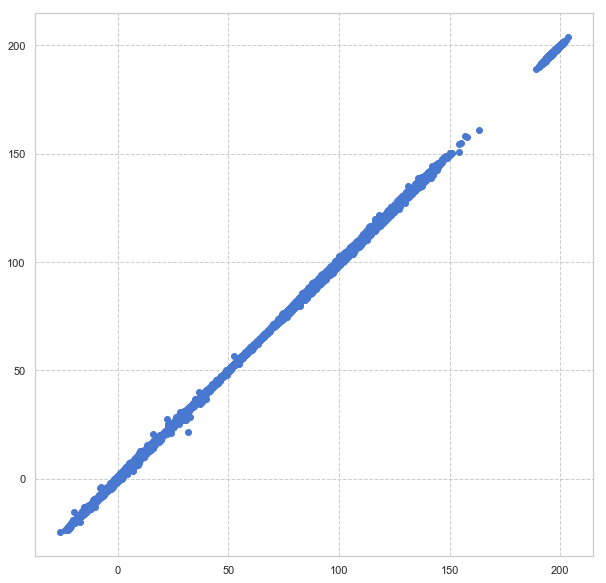

In [14]:
sampled_id = sub3.sample(frac=0.1).index.values
plt.figure(figsize=(10,10))
plt.scatter(x=sub3.loc[sampled_id].scalar_coupling_constant, 
            y=sub4.loc[sampled_id].scalar_coupling_constant)

In [15]:
Path("../submit/ensemble").mkdir(parents=True, exist_ok=True)

In [20]:
weight = np.array([1, 1, 1, 4])
blending_val = np.dot(sub_list_df.values, weight) / weight.sum()

In [22]:
submit_df = pd.DataFrame({"scalar_coupling_constant":blending_val}, index=sub_list_df.index)

In [23]:
submit_df.head()

,scalar_coupling_constant
id,
4658147,13.49447
4658148,182.39833
4658149,1.29366
4658150,181.63999
4658151,11.24332


In [24]:
submit_df.to_csv(f'../submit/ensemble/ensemble_v003_017__019__023__021__022_1vs1vs1vs4.csv', index=True)

In [25]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/ensemble/ensemble_v003_017__019__023__021__022_1vs1vs1vs4.csv -m "ensemble"

100%|██████████████████████████████████████| 64.0M/64.0M [00:12<00:00, 5.22MB/s]
Successfully submitted to Predicting Molecular Properties